# Training a multi-task regression model for neural crest cells

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [2]:
experiment = 'multi_task_DilatedConvModel'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 500 # Length of the input sequence

## Load Data

In [3]:
data= pd.read_csv("../data/normalized_peaks.csv")
data.index.name = 'position #'
ad = data.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': data.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [4]:
data

,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
position #,,,,,,,,,,,,,,,
0,4.658859,4.533672,3.744909,4.677198,3.910345,4.776952,4.074234,4.654862,4.511633,4.800124,3.995971,3.671893,3.417105,4.706086,3.662167
1,4.759777,4.715077,3.915141,4.802952,3.762256,4.759200,4.074087,4.553247,4.739486,4.790696,4.128371,3.930637,3.762256,4.786094,3.768121
2,4.851202,4.694130,3.741332,4.328792,3.891091,4.966067,4.201415,4.509935,4.834991,4.681877,3.961688,4.280661,4.920982,4.964999,4.249963
3,4.918804,4.971179,4.511633,4.538608,4.418892,4.899892,4.531088,4.722845,4.691382,4.823491,4.373438,4.534809,4.642561,5.069323,4.093997
4,5.091230,5.155695,4.589974,4.901204,4.731492,5.050992,4.468658,5.062934,5.074762,4.985431,4.415342,4.427364,4.779970,5.267927,4.454447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,2.385099,1.837305,1.710130,1.723122,2.184391,2.326503,1.820542,1.922973,1.471810,2.651219,2.077131,2.268933,1.552899,2.468091,2.502551
370054,3.310180,3.806458,2.857530,3.068696,3.365575,4.251009,3.218051,3.538135,3.645372,3.987058,3.310180,3.322940,3.442145,3.689176,2.822574
370055,2.983381,2.334474,2.777409,2.813908,2.786776,2.216906,3.053263,2.759981,3.251418,3.467993,2.507627,1.933072,2.805062,2.717196,1.456314


In [5]:
ad.obs

,cell type
cell type,
anterior/posterior axis,anterior/posterior axis
central nervous system,central nervous system
forebrain,forebrain
immature eye,immature eye
integument,integument
lateral plate mesoderm,lateral plate mesoderm
mesenchyme cell,mesenchyme cell
musculature system,musculature system
neural crest,neural crest


In [6]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [7]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [8]:
ad.X[0:5,0:5]

array([[4.65885913, 4.7597768 , 4.8512016 , 4.91880367, 5.09123001],
       [4.53367234, 4.71507734, 4.69412965, 4.97117863, 5.155695  ],
       [3.74490908, 3.91514078, 3.74133195, 4.51163258, 4.58997422],
       [4.6771982 , 4.80295157, 4.3287915 , 4.53860808, 4.90120411],
       [3.91034461, 3.76225644, 3.89109145, 4.41889173, 4.7314921 ]])

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [9]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 333823 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of 200 bp to train the model as follows:

In [10]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,chrom,start,end
0,chr1,5232,5732
1,chr1,5787,6287
2,chr1,10088,10588


## Split data

In [11]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [12]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 303354 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 13390 intervals
Final sizes: train: (15, 303354), val: (15, 17079), test: (15, 13390)


## Make labeled sequence datasets

In [13]:
import grelu.data.dataset

In [14]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [15]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [16]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output. What does this really mean?
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':512,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

In [17]:
print(model)

LightningModel(
  (model): DilatedConvModel(
    (embedding): DilatedConvTrunk(
      (conv_tower): ConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=same)
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): Identity()
            )
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
            (dropout): Dropout(
              (layer): Identity()
            )
            (channel_transform): ChannelTransform(
              (layer): Identity()
            )
          )
          (2): ConvBlock(
            (norm): Norm(
       

## Train model

In [18]:
'''
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)
'''

'\ntrainer = model.train_on_dataset(\n    train_dataset=train_dataset,\n    val_dataset=val_dataset,\n)\n'

## Load best model from checkpoint

In [19]:
#best_checkpoint = trainer.checkpoint_callback.best_model_path
best_checkpoint = "multi_task_DilatedConvModel/2025_26_04_15_05/version_0/checkpoints/epoch=8-step=5337.ckpt"
print(best_checkpoint)

multi_task_DilatedConvModel/2025_26_04_15_05/version_0/checkpoints/epoch=8-step=5337.ckpt


In [20]:
model = grelu.lightning.LightningModel.load_from_checkpoint("multi_task_DilatedConvModel/2025_26_04_15_05/version_0/checkpoints/epoch=8-step=5337.ckpt")

## Evaluate model on the test set

In [21]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 16.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.109100341796875
        test_mse            1.1131290197372437
      test_pearson          0.3876379430294037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Inspect training curves

In [22]:
metrics_path = "multi_task_DilatedConvModel/2025_26_04_15_05/version_0/metrics.csv"

metrics_df = pd.read_csv(metrics_path)

metrics_df.head()

,epoch,step,train_loss_epoch,train_loss_step,val_loss,val_mse,val_pearson
0,0,0,NaN,NaN,7.56159,7.489322,NaN
1,0,49,NaN,1.032562,NaN,NaN,NaN
2,0,99,NaN,1.095526,NaN,NaN,NaN
3,0,149,NaN,1.007000,NaN,NaN,NaN
4,0,199,NaN,0.933161,NaN,NaN,NaN


In [23]:
# Checking if the 'epoch' and 'train_loss' columns exits
if 'epoch' in metrics_df.columns and 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss', marker='o')
else:
    print("Columns 'epoch' or 'train_loss' not found in metrics file.")

Columns 'epoch' or 'train_loss' not found in metrics file.


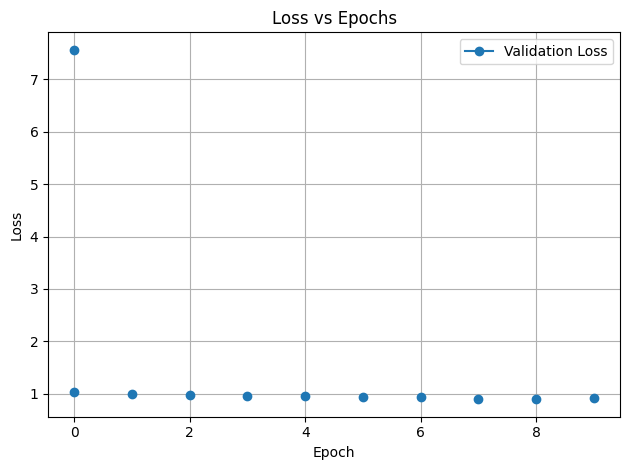

In [24]:
## Plotting validation loss (if logged)
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss', marker='o')

    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

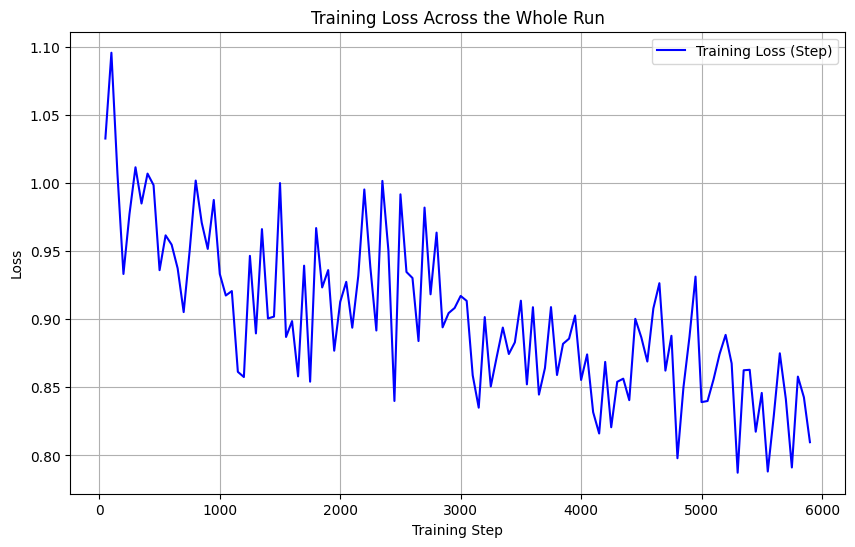

In [25]:
# plot training loss at each step
df_train = metrics_df.dropna(subset=['train_loss_step'])

plt.figure(figsize=(10, 6))
plt.plot(df_train['step'], df_train['train_loss_step'], label='Training Loss (Step)', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Across the Whole Run')
plt.legend()
plt.grid(True)
plt.show()

## Run inference on held out sequences

In [26]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.63it/s]


(13390, 15, 1)

In [27]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.64it/s]


,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,2.358759,2.345015,2.378241,2.336990,2.443420,2.362467,2.364599,2.365907,2.314842,2.356513,2.334921,2.462363,2.486609,2.347343,2.676288
1,2.228658,2.225838,2.126769,2.178507,2.391959,2.247310,2.239637,2.379381,2.201491,2.219942,2.130798,2.467939,2.204454,2.265070,2.452566
2,2.159585,2.132022,2.108021,2.086313,2.396532,2.244897,2.227186,2.403383,2.208397,2.139176,2.027526,2.503089,2.153519,2.205695,2.714134
3,2.835561,2.684560,2.878422,2.922115,2.987158,2.863344,3.024207,2.799343,2.803246,2.891967,3.018428,2.748607,3.041377,2.807091,2.598876
4,2.780553,2.938087,2.819865,2.764672,2.700282,2.762955,2.827732,2.703271,2.746160,2.884923,2.832764,2.537047,2.854645,2.753439,2.311591


## Correlations for each cell type in test set

In [28]:
test_metrics.sort_values(by = 'test_pearson', ascending= False)

,test_mse,test_pearson
central nervous system,1.234120,0.442612
neural keel,1.066109,0.439887
neural stem cell,1.160116,0.439134
forebrain,1.063876,0.429782
primary neuron,1.096370,0.417226
mesenchyme cell,1.172925,0.412634
lateral plate mesoderm,1.007619,0.409487
immature eye,1.103563,0.405965
anterior/posterior axis,1.033624,0.399719
segmental plate,1.124806,0.393529


In [29]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

## Inpsecting the performance of the trained model

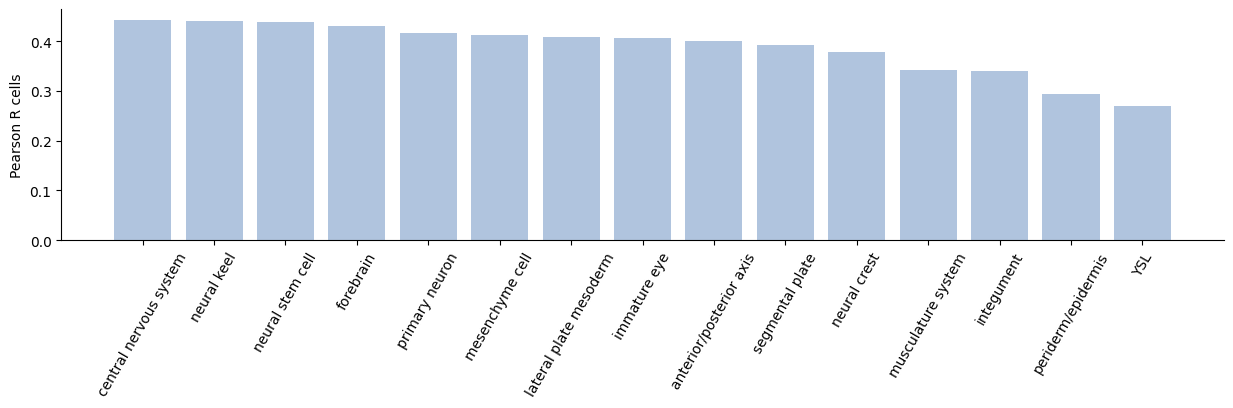

In [30]:
from plotlib import _bar_plot
import matplotlib.pyplot as plt

corrvalues_sorted = test_metrics.sort_values(by = 'test_pearson', ascending= False)

ax = _bar_plot(corrvalues_sorted['test_pearson'], ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues_sorted.index, rotation = 60)
plt.show()

## Interpreting model predictions (for central nervous system)

**Note**: We want to find out what the model thinks that is important in the sequence to get a high signal.
grelu has a few methods that you can easily select (saliency, integratedgradients, and deepliftshap)
However, you won't be able to use deepliftshap if you trained a model with GELU or with attention

Based on the Pearson correlation coefficients from the previous section, we use the cell type with the highest correlation coefficient (i.e. strongest prediction)

### Plot cell type with highest pearson correlation

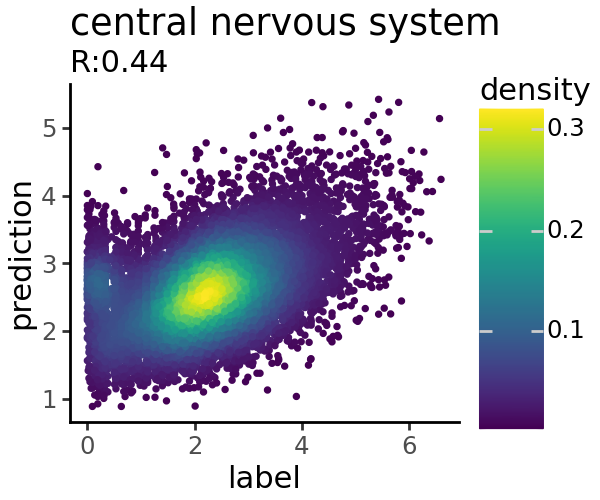

In [31]:
import grelu.visualize
import plotnine as p9
from scipy.stats import pearsonr

fig = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    tasks= [1],
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)



pcorr = str(round(test_metrics['test_pearson'].values[1], 2))
fig + p9.labs(title = f'{ad.obs_names[1]}',
              subtitle = f'R:{pcorr}') 

### Plot performance of model on all cell types

In [32]:
# create list of predictions
n = preds.shape[1]
preds_list = [preds[:,e,:].reshape(-1) for e in range(n)]
len(preds_list)

15

In [33]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

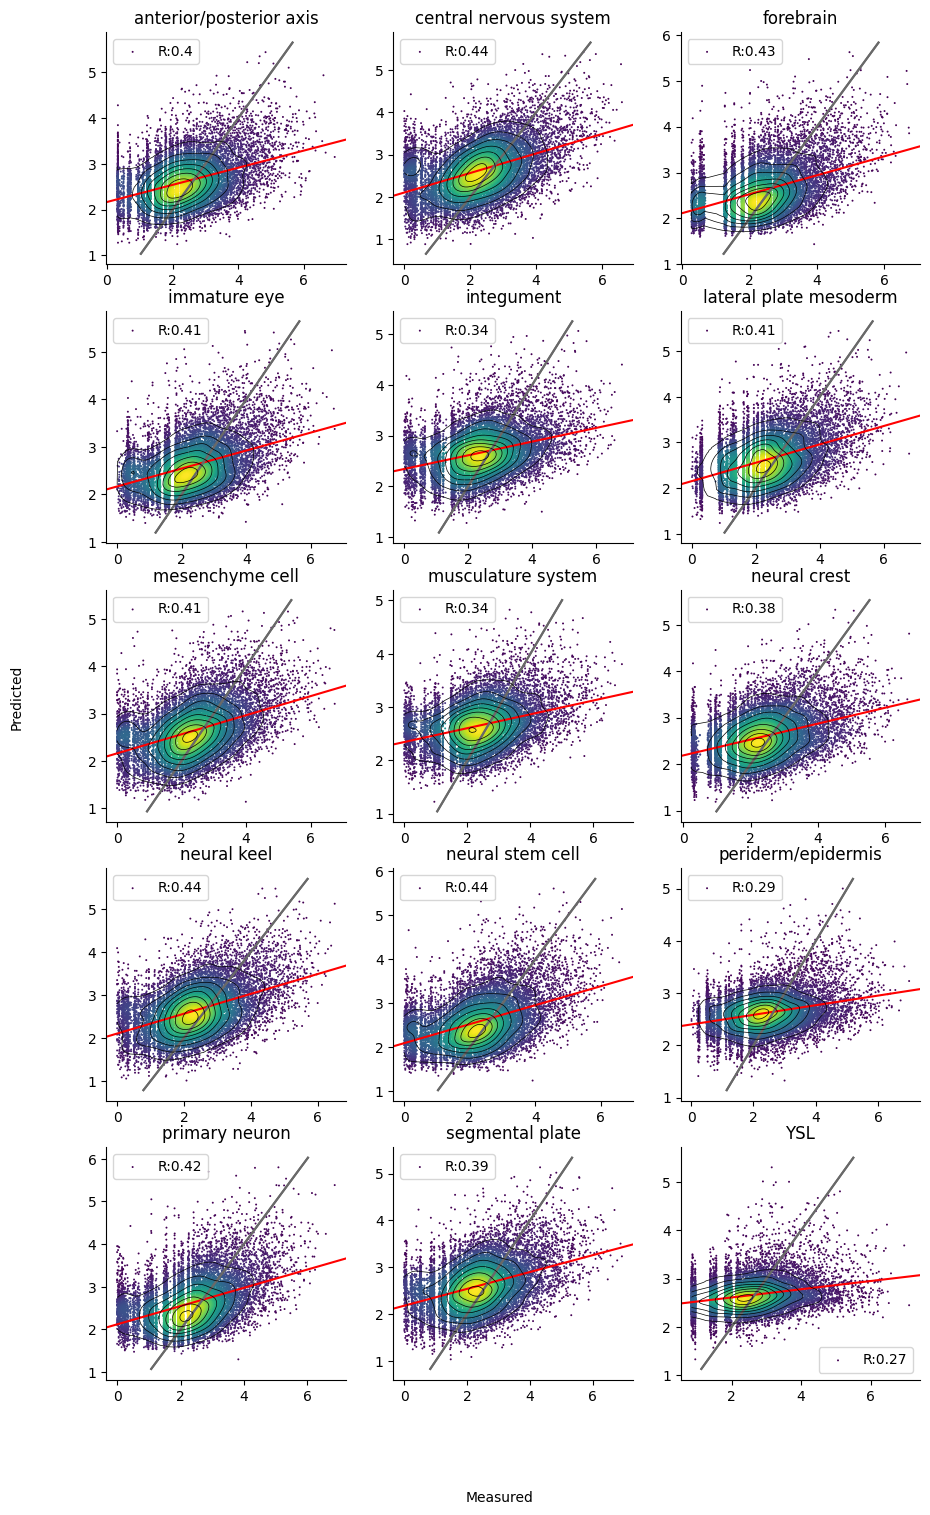

In [34]:
from plotlib import plot_scatter

allfig = plot_scatter(list(ad_test.X.toarray()), preds_list, titles = ad_test.obs_names, xlabel = 'Measured', ylabel = 'Predicted', 
                      sizes = 2, contour = True, color_density = True, color = 'grey', lw = 0., legend = True, 
                      include_fit = True, include_mainvar = False, diagonal = True)
plt.show()

In [35]:
ad_test.var

,chrom,start,end
49447,chr4,1366,1866
49448,chr4,2941,3441
49449,chr4,4405,4905
49450,chr4,5949,6449
49451,chr4,12663,13163
...,...,...,...
62832,chr4,78056155,78056655
62833,chr4,78058123,78058623
62834,chr4,78083093,78083593
62835,chr4,78084337,78084837


In [36]:
preds_df[['central nervous system']].sort_values(by = "central nervous system", ascending=False)

,central nervous system
13232,5.421365
13234,5.376625
4600,5.373671
46,5.337633
1279,5.313001
...,...
11997,0.966041
3894,0.922321
9989,0.889220
8131,0.884187


In [37]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    ad_test.var,
    output_type="strings",
    genome=genome
)
input_seq = input_seqs[1279]

len(input_seq)

500

In [38]:
input_seq[:10]

'GTCATATTAT'

In [39]:
len(input_seqs)

13390

`input_seqs` contains sequences for each of the 13390 chromosomes in the test set `ad_test`.

### Forward propagation of influence using integrated gradients

In [40]:
from grelu.transforms.prediction_transforms import Aggregate

cns_peaks = Aggregate(
    tasks = ["central nervous system"],
    model = model,
)

cns_peaks

Aggregate()

In [41]:
import grelu.interpret.score

attrs = grelu.interpret.score.get_attributions(
    model, input_seq, prediction_transform=cns_peaks, device=0,
    method="integratedgradients",
)

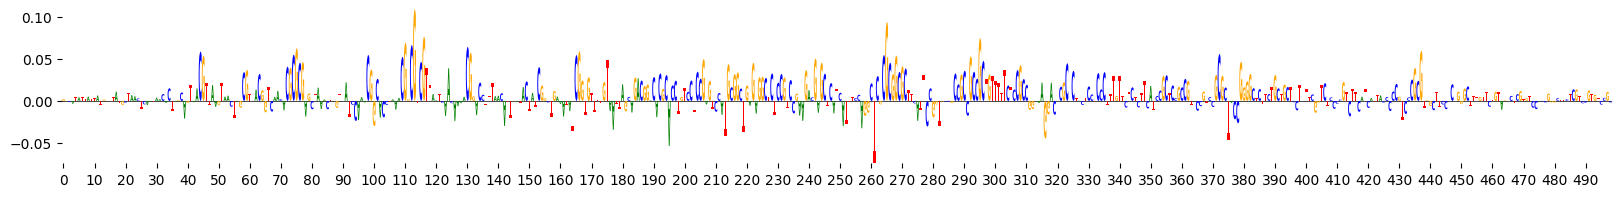

In [42]:
grelu.visualize.plot_attributions(
    attrs, 
    ticks=10,
)

_ = plt.show()

### Using integrated gradients from Captum

In [43]:
from utils import get_captum_integrated_gradients

prediction_transform=cns_peaks
device = 0
correct_grad = False

captum_attrs = get_captum_integrated_gradients(
    model, input_seq, genome, prediction_transform=cns_peaks, device=0,
    multiply_by_inputs= True,
)

captum_attrs

array([[[-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -1.39245680e-03, ...,
         -0.00000000e+00, -1.90301971e-03, -0.00000000e+00],
        [ 2.34390905e-03, -0.00000000e+00, -0.00000000e+00, ...,
          1.08175998e-02,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00, -6.66071165e-05, -0.00000000e+00, ...,
         -0.00000000e+00,  0.00000000e+00,  3.17290381e-03]]])

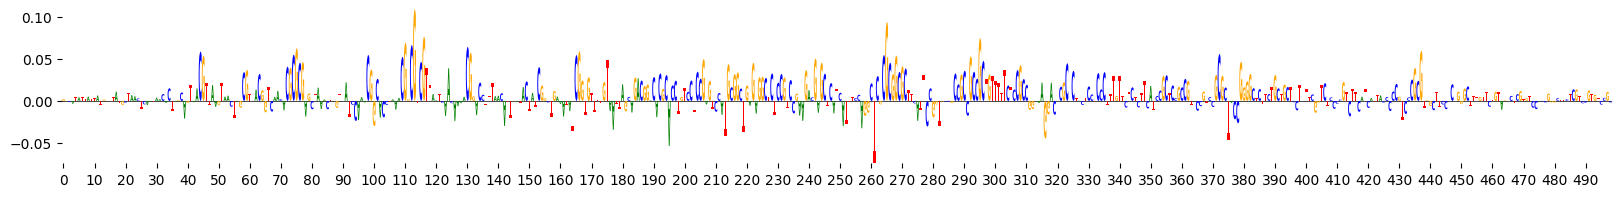

In [44]:
grelu.visualize.plot_attributions(
    captum_attrs, 
    ticks=10,
)

_ = plt.show()

In [45]:
captum_attrs = get_captum_integrated_gradients(
    model, input_seq, genome, prediction_transform=cns_peaks, device=0,
    multiply_by_inputs= False,
)

captum_attrs

array([[[-1.16463590e-03, -8.56718094e-04,  4.97918248e-04, ...,
         -4.52593014e-03, -3.46307286e-03, -6.47978068e-03],
        [-1.23398427e-03, -1.12628240e-03, -1.39245680e-03, ...,
         -7.40360584e-03, -1.90301970e-03, -6.55565473e-03],
        [ 2.34390905e-03, -2.98822409e-04, -1.58361875e-03, ...,
          1.08175998e-02,  2.09011579e-03,  5.77866181e-03],
        [-3.27826876e-03, -6.66071228e-05, -1.13775595e-03, ...,
         -8.27691120e-05,  5.63773895e-03,  3.17290381e-03]]])

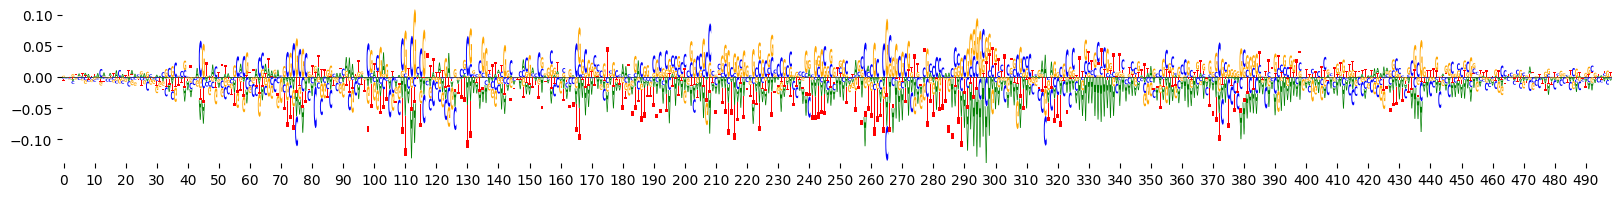

In [46]:
grelu.visualize.plot_attributions(
    captum_attrs, 
    ticks=10,
)

_ = plt.show()

### From local propagation results to global interpretation

The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).



In [47]:
'''
%%time
import grelu.interpret.modisco
grelu.interpret.modisco.run_modisco(
    model,
    seqs=ad_test.var, 
    genome=genome,
    prediction_transform=cns_peaks, # Base importance scores will be calculated with respect to this output
    meme_file="../data/danRer11.meme", # We will compare the Modisco CWMs to motifs
    method="saliency", # Base-level attribution scores will be calculated using ISM. You can also use "saliency".
    out_dir=experiment,
    batch_size=256,
    devices=0,
    num_workers=8,
    window=100, # ISM scores will be calculated over the central 100 bp of each peak
    seed=0,
)

'''

'\n%%time\nimport grelu.interpret.modisco\ngrelu.interpret.modisco.run_modisco(\n    model,\n    seqs=ad_test.var, \n    genome=genome,\n    prediction_transform=cns_peaks, # Base importance scores will be calculated with respect to this output\n    meme_file="../data/danRer11.meme", # We will compare the Modisco CWMs to motifs\n    method="saliency", # Base-level attribution scores will be calculated using ISM. You can also use "saliency".\n    out_dir=experiment,\n    batch_size=256,\n    devices=0,\n    num_workers=8,\n    window=100, # ISM scores will be calculated over the central 100 bp of each peak\n    seed=0,\n)\n\n'

In [48]:
cns_peaks

Aggregate()